# DRAFT IMG-OPT-4

Maked simulated data for the IMG-OPT-2 PSF image quality test

Reqs.:
- Ref. Overleaf doc IMG_OPT_02_Test_Description_PSF_Image_Quality

1. METIS-1408: Quality and alignment of the optical components within Mid-infrared ELT Imager and
Spectrograph (METIS) shall provide diffraction limited performance (Strehl ≥ 80 %)
at λ > 3μm in all modes over the entire FOV.
2. METIS-1409: The Instrument Wavefront Error (WFE) shall satisfy the diffraction limit requirement
(Strehl>0.8) at lambda = 3 μm for IMG (both LM and NQ) and IMG. The minimum
RMS WFE below shall be satisfied over the full Field Of View (FOV) relevant to the
given optical path.
3. METIS-2864: The minimum Strehl ratio of the WCU+CFO+IMG-LM optical path shall be >80% at
3.3μm over the entire field of view.
4. METIS-3503: METIS shall be able to characterise the shape of the instrument PSF across the entire
FoV using the WCU.

The procedure for measuring the image quality follows that of IMG-OPT-01, but with additional exposures
made at positions designed to obtain fully spatially sampled imaging. A basic offset of half a pixel is used
for the PSF image quality measurements in this test in horizontal, vertical, and diagonal directions. We also
need to achieve a significantly higher SNR for accurate measurement of the FWHM, and better control of
calibration and flat fielding errors for measurement of the Encircled Energy. The flat field will be derived
from IMG-RAD-04.

In [61]:
import numpy as np
from astropy.io import fits
from astropy import units as u
from astropy.wcs import WCS

import scipy

from matplotlib import pyplot as plt
from matplotlib import colors

import time

In [2]:
import scopesim as sim
sim.bug_report()

# Edit this path if you have a custom install directory, otherwise comment it out. [For ReadTheDocs only]
sim.link_irdb("../../../")

Python:
3.10.18 (main, Jun  5 2025, 13:08:10) [GCC 11.2.0]

Installed Python packages:
           anisocado: 0.3.0
         astar-utils: 0.3.3
             astropy: 6.1.7
      beautifulsoup4: 4.13.4
            docutils: 0.19
               httpx: 0.28.1
                lxml: 5.4.0
          matplotlib: 3.10.5
      more-itertools: 10.7.0
               numpy: 1.26.4
           packaging: 25.0
               pooch: 1.8.2
              pyyaml: 6.0.2
               scipy: 1.15.3
            scopesim: 0.10.0
       scopesim_data: could not be loaded.
  scopesim_templates: 0.6.2
         skycalc-ipy: 0.5.3
             synphot: 1.6.0
                tqdm: 4.67.1

Installed IRDB packages:
  Armazones: 2023-07-11
        ELT: 2025-06-30
      METIS: 2025-06-30

Operating System info:
   System: Linux
  Release: 6.12.13-200.fc41.aarch64
  Version: #1 SMP PREEMPT_DYNAMIC Sat Feb  8 20:30:50 UTC 2025
  Machine: aarch64


In [3]:
# simulate observations with METIS (comment this out if packages already exist)
#sim.download_packages(["METIS", "ELT", "Armazones"])

In [4]:
# set up instrument for LM imaging

cmd = sim.UserCommands(use_instrument='METIS', set_modes=['wcu_img_lm'])

In [5]:
# alternative: Mp imaging and different filter

#cmd_2 = sim.UserCommands(use_instrument="METIS", set_modes=["img_lm"],
#                         properties={"!OBS.filter_name": "Mp", "!OBS.exptime": 100., "!DET.dit": 200})

## 1. Configure WCU to LM pinhole mask.

In [6]:
metis = sim.OpticalTrain(cmd)

In [7]:
metis.effects.pprint_all()

    element                  name                       class             included
---------------- --------------------------- ---------------------------- --------
       METIS_WCU                  wcu_source                    WCUSource     True
       METIS_WCU            wcu_relay_optics                  SurfaceList     True
       METIS_WCU        pupil_masks : [open]               PupilMaskWheel     True
       METIS_WCU           wcu_fits_keywords            ExtraFitsKeywords     True
           METIS          common_fore_optics                  SurfaceList     True
           METIS         adc_wheel : [False]                     ADCWheel    False
           METIS        slit_wheel : [False]                    SlitWheel    False
           METIS                   cold_stop            PupilTransmission     True
           METIS        common_fits_keywords            ExtraFitsKeywords     True
           METIS           cfo_fits_keywords            ExtraFitsKeywords     True
    

In [8]:
wcu = metis['wcu_source']

In [9]:
print(wcu.fpmask)

FPMask: "open"
Angle:        0 deg
Shift:        [0, 0] arcsec



In [10]:
wcu.set_fpmask('grid_lm')  # change to LM pinhole mask

In [11]:
print(wcu.fpmask)

FPMask: "grid_lm"
Angle:        0 deg
Shift:        (0, 0) arcsec



## 2. Set the WCU Flux Controlling Mask to "CLOSED".

In [12]:
wcu.set_bb_aperture(value = 0.)

In [13]:
print(wcu.bb_aperture)

0.0


## 3. Set the WCU BB source to 1000 K.

In [14]:
wcu.set_temperature(bb_temp=1000*u.K)

In [15]:
print(wcu.bb_temp)

1000.0 K


## 4. Wait for BB source to reach temperature.

In [16]:
# placeholder in lieu of a thermal model
time.sleep(0.5)

## 5. While BB reaches temperature, take background exposure

In [17]:
# see current observing params

print("\nAll OBS parameters:")
for key, value in cmd['OBS'].items():
    print(f"  {key}: {value}")


All OBS parameters:
  !auto_exposure.fill_frac: 0.75
  instrument: METIS
  modes: ['wcu_img_lm']
  airmass: 1.2
  declination: -30
  hour_angle: 0
  pupil_angle: 0
  exptime: 1.0
  dit: 1
  ndit: 1
  pupil_transmission: 1.0
  tplname: METIS_img_lm_obs_GenericOffset
  catg: SCIENCE
  tech: IMAGE,LM
  type: OBJECT
  mjdobs: 2027-05-04T02:30:00
  tplstart: 2027-05-04T02:30:00
  tplno: 0
  tplexpno: 0
  obsname: MyScienceTest
  ra: 0.0
  dec: 0.0
  filter_name: Lp
  nd_filter_name: open
  ins_mode: IMG_LM
  psf_file: PSF_SCAO_9mag_06seeing.fits
  slit: False
  adc: False
  detector_readout_mode: fast


In [18]:
# compile the observation

metis.observe()

astar.scopesim.optics.optical_train - Observing empty field


In [19]:
# do readout with observation params

# Oliver Cz. recommends just using ndit and dit (not exptime)
outhdul = metis.readout(ndit = 10, dit = 1.)[0]

astar.scopesim.effects.electronic - Exposure parameters: DIT = 1.000 s, NDIT = 10
astar.scopesim.effects.electronic - Total exposure time: 10.000 s
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.effects.electronic - Applying gain 4.0
astar.scopesim.effects.electronic - Applying digitization to dtype float32.
astar.scopesim.effects.electronic - Exposure parameters: DIT = 1.000 s, NDIT = 10
astar.scopesim.effects.electronic - Total exposure time: 10.000 s


In [20]:
outhdul.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      82   ()      
  1  DET1.DATA     1 ImageHDU        50   (2048, 2048)   float32   


In [21]:
np.std(outhdul[1].data)

5.5359535

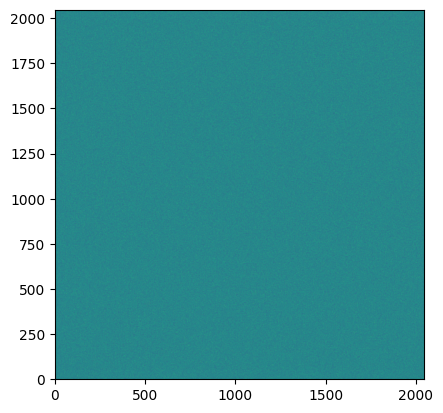

In [22]:
# display

plt.imshow(outhdul[1].data, origin='lower')
plt.show()

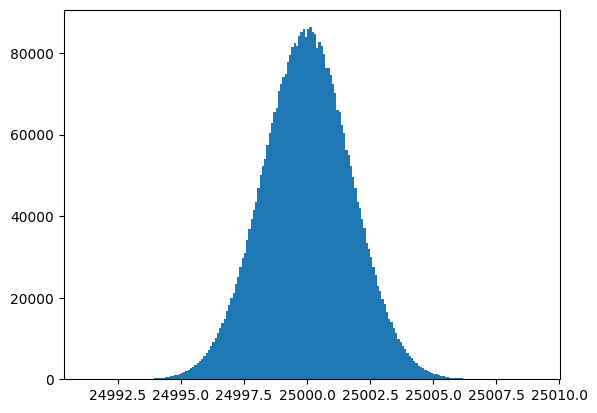

In [35]:
plt.hist(outhdul[1].data.ravel(), bins=200)
plt.show()

## 6. Set the WCU Flux Controlling Mask to "OPEN".

In [23]:
wcu.set_bb_aperture(value = 1.)

## 7. Take science exposure with same params as background

In [24]:
# recompile
metis.observe()
# get the readout
outhdul = metis.readout(ndit = 10, dit = 1.)[0]

astar.scopesim.optics.optical_train - Observing empty field
astar.scopesim.effects.electronic - Exposure parameters: DIT = 1.000 s, NDIT = 10
astar.scopesim.effects.electronic - Total exposure time: 10.000 s
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.effects.electronic - Applying gain 4.0
astar.scopesim.effects.electronic - Applying digitization to dtype float32.
astar.scopesim.effects.electronic - Exposure parameters: DIT = 1.000 s, NDIT = 10
astar.scopesim.effects.electronic - Total exposure time: 10.000 s


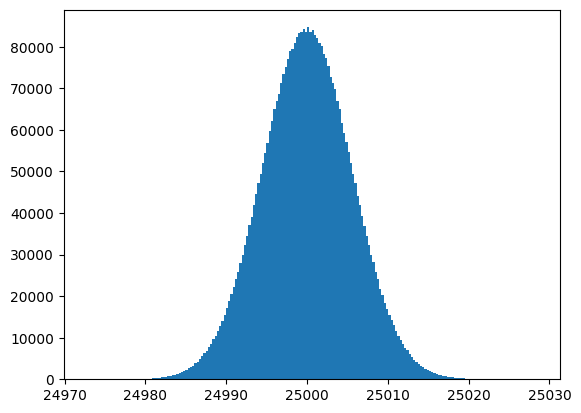

In [41]:
plt.hist(outhdul[1].data.ravel(), bins=200)
plt.show()

## 8. Repeat for other WCU Focal Plane Masks.

In [25]:
# fpmasks:  ["open", "pinhole_lm", "pinhole_n", "grid_lm"]

fpmasks_list = ["open", "pinhole_lm", "pinhole_n", "grid_lm"]
for mask in fpmasks_list:
    print('Generating ' + str(mask)) 
    wcu.set_fpmask(mask)
    wcu.set_temperature(bb_temp=1000*u.K)
    wcu.set_bb_aperture(value = 0.4)
    metis.observe()
    outhdul = metis.readout(ndit = 1, exptime = 0.2)[0]
    #outhdul[1].data
    outhdul.writeto(f"IMG_OPT_02_wcu_focal_plane_{mask}_LM.fits", overwrite=True)

    #plt.imshow(outhdul[1].data, origin='lower')
    #plt.show()

Generating open
astar.scopesim.optics.optical_train - Observing empty field
astar.scopesim.effects.electronic - Requested exposure time: 0.200 s
astar.scopesim.effects.electronic - Required DIT without saturation: 0.000 s
astar.scopesim.effects.electronic - WARNING: DIT = 0.000 s < MINDIT = 0.040 s
astar.scopesim.effects.electronic - WARNING: The detector will likely be saturated!
astar.scopesim.effects.electronic - Exposure parameters: DIT = 0.040 s, NDIT = 5
astar.scopesim.effects.electronic - Total exposure time: 0.200 s
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.effects.electronic - Applying gain 4.0
astar.scopesim.effects.electronic - Applying digitization to dtype float32.
astar.scopesim.effects.electronic - Exposure parameters: DIT = 0.040 s, NDIT = 5
astar.scopesim.effects.electronic - Total exposure time: 0.200 s
Generating pinhole_lm
astar.scopesim.optics.optical_train - Observing empty field
astar.scopesim.effects.electronic - Re

In [13]:
# do the same for N band

cmd = sim.UserCommands(use_instrument='METIS', set_modes=['wcu_img_lm'])
wcu = metis['wcu_source']

fpmasks_list = ["open", "pinhole_lm", "pinhole_n", "grid_lm"]
for mask in fpmasks_list:
    print('Generating ' + str(mask)) 
    wcu.set_fpmask(mask)
    wcu.set_temperature(bb_temp=1000*u.K)
    wcu.set_bb_aperture(value = 0.4)
    metis.observe()
    outhdul = metis.readout(ndit = 1, exptime = 0.2)[0]
    #outhdul[1].data
    outhdul.writeto(f"IMG_OPT_02_wcu_focal_plane_{mask}_LM.fits", overwrite=True)

Generating open
astar.scopesim.optics.optical_train - Observing empty field
astar.scopesim.effects.electronic - Requested exposure time: 0.200 s
astar.scopesim.effects.electronic - Required DIT without saturation: 0.000 s
astar.scopesim.effects.electronic - WARNING: DIT = 0.000 s < MINDIT = 0.040 s
astar.scopesim.effects.electronic - WARNING: The detector will likely be saturated!
astar.scopesim.effects.electronic - Exposure parameters: DIT = 0.040 s, NDIT = 5
astar.scopesim.effects.electronic - Total exposure time: 0.200 s
astar.scopesim.detector.detector_manager - Extracting from 1 detectors...
astar.scopesim.effects.electronic - Applying gain 4.0
astar.scopesim.effects.electronic - Applying digitization to dtype float32.
astar.scopesim.effects.electronic - Exposure parameters: DIT = 0.040 s, NDIT = 5
astar.scopesim.effects.electronic - Total exposure time: 0.200 s
Generating pinhole_lm
astar.scopesim.optics.optical_train - Observing empty field
astar.scopesim.effects.electronic - Re

In [67]:
# do a hackneyed aberration: blurring made to look like defocus 

sci_data_blur = scipy.ndimage.gaussian_filter(outhdul[1].data, sigma=3)

---
0.0055
[[-2.816  -2.8105 -2.805  ...  2.7995  2.805   2.8105]
 [-2.816  -2.8105 -2.805  ...  2.7995  2.805   2.8105]
 [-2.816  -2.8105 -2.805  ...  2.7995  2.805   2.8105]
 ...
 [-2.816  -2.8105 -2.805  ...  2.7995  2.805   2.8105]
 [-2.816  -2.8105 -2.805  ...  2.7995  2.805   2.8105]
 [-2.816  -2.8105 -2.805  ...  2.7995  2.805   2.8105]]


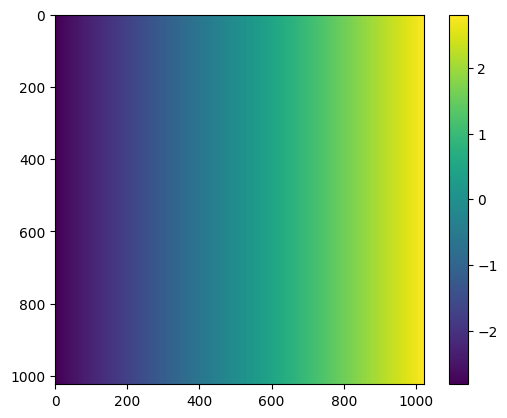

defocus_phase
[[1.17767602e+10 1.17537812e+10 1.17308471e+10 ... 1.17079579e+10
  1.17308471e+10 1.17537812e+10]
 [1.17537812e+10 1.17308022e+10 1.17078681e+10 ... 1.16849789e+10
  1.17078681e+10 1.17308022e+10]
 [1.17308471e+10 1.17078681e+10 1.16849340e+10 ... 1.16620448e+10
  1.16849340e+10 1.17078681e+10]
 ...
 [1.17079579e+10 1.16849789e+10 1.16620448e+10 ... 1.16391556e+10
  1.16620448e+10 1.16849789e+10]
 [1.17308471e+10 1.17078681e+10 1.16849340e+10 ... 1.16620448e+10
  1.16849340e+10 1.17078681e+10]
 [1.17537812e+10 1.17308022e+10 1.17078681e+10 ... 1.16849789e+10
  1.17078681e+10 1.17308022e+10]]


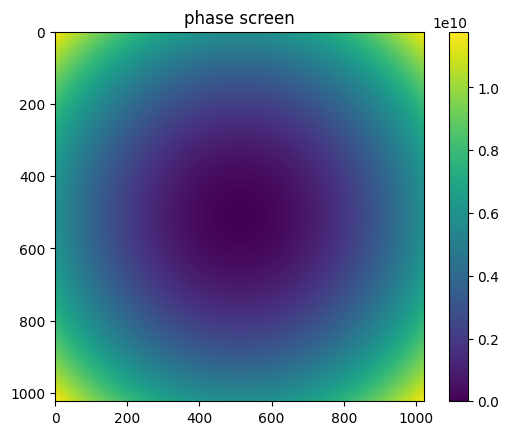

min, defocus_phase
0.0


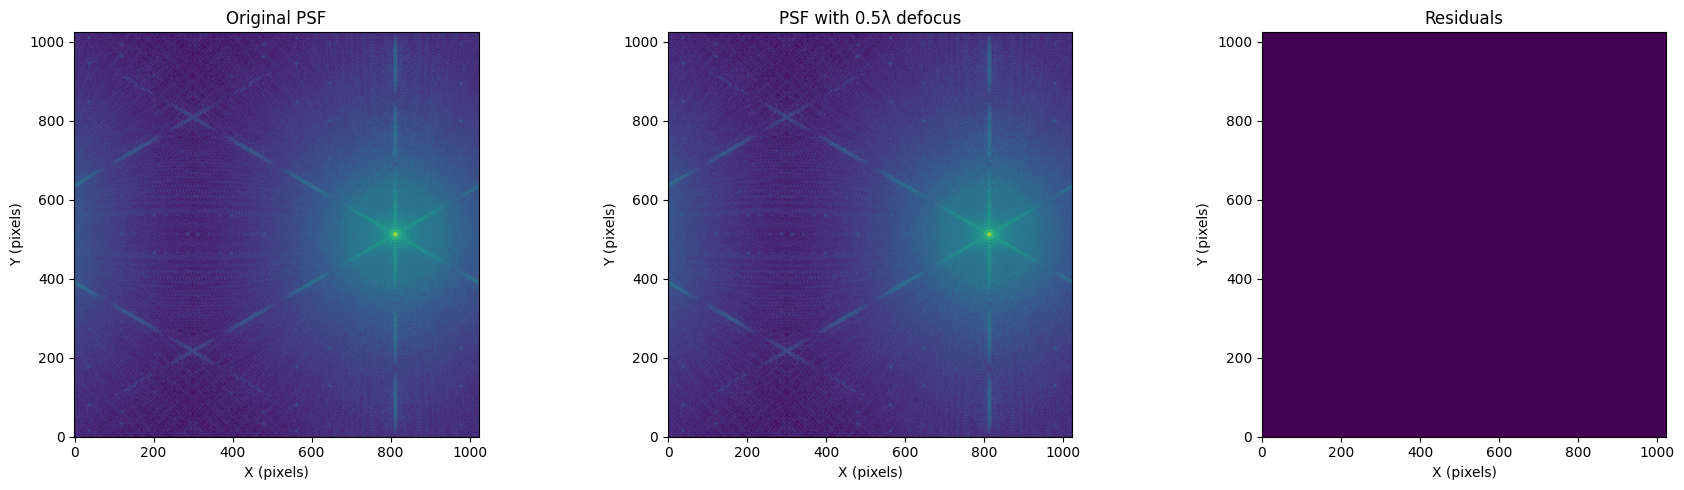

[[1819277.1  1035980.56  384549.84 ...  362652.4   353837.38  321517.12]
 [ 326847.3   274386.62  221351.62 ...  459766.3   665895.4  1453927.6 ]
 [1747510.5  1035163.25  348527.06 ...  412220.16  677257.75 2040041.  ]
 ...
 [ 349068.25  535686.4   964715.1  ...  184707.08  234917.83  651730.  ]
 [ 715373.7   373138.8   726833.44 ...  208540.    629294.2  2099847.8 ]
 [2487657.5  1239300.2   549391.4  ...  257426.22  582628.7  1525716.2 ]]
----
[[1819277.125    1035980.5625    384549.84375  ...  362652.40625
   353837.375     321517.125   ]
 [ 326847.3125    274386.625     221351.625    ...  459766.3125
   665895.375    1453927.625   ]
 [1747510.5      1035163.25      348527.0625   ...  412220.15625
   677257.75     2040041.      ]
 ...
 [ 349068.25      535686.375     964715.125    ...  184707.078125
   234917.828125  651730.      ]
 [ 715373.6875    373138.8125    726833.4375   ...  208540.
   629294.1875   2099847.75    ]
 [2487657.5      1239300.25      549391.375    ...  257426.21

In [59]:
'''
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import ndimage
from scipy.fft import fft2, ifft2, fftshift, ifftshift

ln_img_plate_scale = 5.5e-3 # 5.5 masec/pix

def add_defocus_to_psf(psf_data, defocus_waves=0.5, wavelength=3.3e-6, pupil_diameter=39.0):
    """
    Add defocus to an existing PSF by applying a defocus phase in the pupil plane.
    
    Parameters:
    -----------
    psf_data : 2D array
        Input PSF data
    defocus_waves : float
        Defocus in waves (RMS)
    wavelength : float
        Wavelength in meters
    pupil_diameter : float
        Pupil diameter in meters
    
    Returns:
    --------
    2D array with defocused PSF
    """
    # Get PSF dimensions
    ny, nx = psf_data.shape
    
    # Create coordinate grids
    x = np.linspace(-nx//2, nx//2-1, nx)
    y = np.linspace(-ny//2, ny//2-1, ny)
    X, Y = np.meshgrid(x, y)
    
    # Convert to angular coordinates (assuming PSF is centered)
    theta_x = X * ln_img_plate_scale
    theta_y = Y * ln_img_plate_scale

    print('---')
    print(ln_img_plate_scale)
    print(theta_x)

    plt.imshow(theta_x)
    plt.colorbar()
    plt.show()
    
    # phase screen (defocus: quadratic phase error)
    defocus_phase = 2 * np.pi * defocus_waves * (theta_x**2 + theta_y**2) / (wavelength / pupil_diameter)

    print('defocus_phase')
    print(defocus_phase)
    plt.imshow(defocus_phase)
    plt.title('phase screen')
    plt.colorbar()
    plt.show()

    print('min, defocus_phase')
    print(np.min(defocus_phase))
    
    # Apply defocus by multiplying PSF with phase factor
    defocused_psf = psf_data * np.exp(1j * defocus_phase)
    
    # Take absolute value to get intensity
    return np.sqrt(np.abs(defocused_psf)**2)

    

# Load your existing PSF
psf_file = '/playing_with_scopesim/METIS_LMS_olivier_notebooks/inst_pkgs/METIS/PSF_LM_9mag_06seeing.fits'
hdul = fits.open(psf_file)
psf_data = hdul[1].data
hdul.close()

# Add defocus
psf_data = np.roll(psf_data, 300)
defocused_psf = add_defocus_to_psf(psf_data, defocus_waves=10)

# Plot comparison
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
ax1.imshow(psf_data, origin='lower', cmap='viridis', norm='log')
ax1.set_title('Original PSF')
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')

ax2.imshow(defocused_psf, origin='lower', cmap='viridis', norm='log')
ax2.set_title('PSF with 0.5λ defocus')
ax2.set_xlabel('X (pixels)')
ax2.set_ylabel('Y (pixels)')

ax3.imshow(defocused_psf-psf_data, origin='lower', cmap='viridis', norm='log')
ax3.set_title('Residuals')
ax3.set_xlabel('X (pixels)')
ax3.set_ylabel('Y (pixels)')

plt.tight_layout()
plt.show()

print(psf_data)
print('----')
print(defocused_psf)
print('----')
print(defocused_psf-psf_data)
'''

In [54]:
psf_file = '/playing_with_scopesim/METIS_LMS_olivier_notebooks/inst_pkgs/METIS/PSF_LM_9mag_06seeing.fits'
hdul = fits.open(psf_file)

In [57]:
hdul[1].data


array([[  72000.7  ,   79234.77 ,   82422.35 , ...,   76337.06 ,
          78962.555,   76218.55 ],
       [  65615.95 ,  337961.62 ,  570541.56 , ...,  262229.   ,
         601633.   ,  377837.03 ],
       [  66810.3  ,  587690.   ,  956579.25 , ...,  344187.22 ,
        1039869.56 ,  665311.25 ],
       ...,
       [  75901.914,  385686.66 ,  494906.22 , ...,  111157.62 ,
         505745.53 ,  383858.66 ],
       [  61989.61 ,  605001.7  ,  963353.7  , ...,  349213.72 ,
        1019459.6  ,  632101.3  ],
       [  64843.88 ,  329781.53 ,  526242.4  , ...,  261678.58 ,
         567381.3  ,  345643.72 ]], dtype='>f4')

## Notes RvB:

##    take deep PSF measurements for all pupil stops in the Imager Subsystem (IMG)-PP1. APP would be addressed in HCI test.

In [ ]:
# IMG-LM and IMG-N pupil wheels are not available in ScopeSim yet

In [ ]:
# will also need to apply (x,y) offsets to all PSFs